# Fine-tuning Stable Diffusion with DreamBooth

## Learning Objectives
- Learn how to use pre-trained Stable Diffusion via Keras CV.
- Learn how to fine-tune Stable Diffusion using DreamBooth method.

## Introduction

In this lab, we implement DreamBooth, a fine-tuning technique to teach new visual concepts to Stable Diffusion with just 3 - 5 images. 

DreamBooth was proposed in [DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation](https://arxiv.org/abs/2208.12242) by Ruiz et al.<br>
This lab assumes that you have a basic familiarity with diffusion models. If you don't, please first refer to [diffusion_model.ipynb](./diffusion_model.ipynb) first.

## Stable Diffusion on Keras CV
In this lab, we fine-tune Stable Diffusion, although DreamBooth itself can be applied to any text-conditioned image generation model.

Stable Diffusion is introduced in ["High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/abs/2112.10752) paper. <br>
The Latent Diffusion Models (LDMs) proposed in this paper suggests applying diffusion models to image latent space, instead of the image pixel space. The latent space is obtained using an additional pre-trained [Variational Autoencoder](./variational_autoencoder.ipynb).

<img width="1084" alt="image" src="https://github.com/GoogleCloudPlatform/asl-ml-immersion/assets/6895245/6fced434-99b7-49aa-8828-ed760b519f63">


While there exist multiple open-source implementations that allow you to easily create images from textual prompts, [KerasCV](https://keras.io/keras_cv/)'s implementation offers a few distinct advantages. <br>
These include [XLA(Accelerated Linear Algebra)](https://www.tensorflow.org/xla) compilation and [mixed precision](https://www.tensorflow.org/guide/mixed_precision) support, which together achieve state-of-the-art generation speed.

Let's generate images using Keras CV's Stable Diffusion implementation.

**It takes a few minutes for the first run. Refer to [this guide](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/) for a more detailed performance comparison.**

In [2]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB, compute capability 8.0
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL++-M license at https://github.com/Stability-AI/stablediffusion/blob/main/LICENSE-MODEL
50/50 [==============================] - 68s 127ms/step


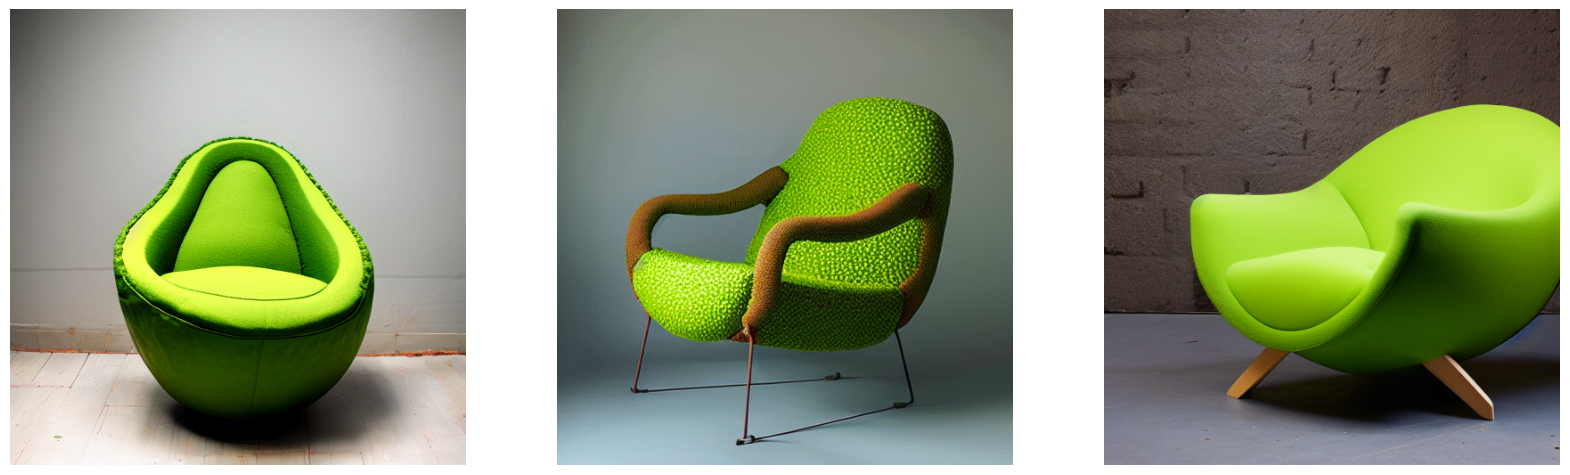

In [3]:
import keras_cv
import matplotlib.pyplot as plt
from tensorflow import keras

# Set mixed precision
keras.mixed_precision.set_global_policy("mixed_float16")

stable_diffusion_model = keras_cv.models.StableDiffusionV2(
    img_width=512, img_height=512, jit_compile=True
)

# Let's make sure to warm up the model
images = stable_diffusion_model.text_to_image(
    "An avocado armchair",
    batch_size=3,
)

plt.figure(figsize=(20, 20))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

Looks good! But we want to "personalize" this image generation model a bit.

Let's try to do it in the next section with DreamBooth!

## DreamBooth fine-tuning

DreamBooth, in a sense, is similar to the traditional way of fine-tuning a text-conditioned diffusion model, but instead of [completely tuning the pre-trained weights toward a specific domain](https://keras.io/examples/generative/finetune_stable_diffusion/) with a relatively large dataset, it is designed to make a model learn a new concept and "personalize" a model with **3-5 images**.

DreamBooth can achieve it by binding a unique identifier (`hta` in this notebook) with a target concept (e.g., your dog) to learn the new concept without forgetting what it learned in the pre-training. <br>
After training, the unique identifier can be used to synthesize novel photorealistic images of the subject contextualized in different scenes.

The usage of DreamBooth is very versatile. By teaching Stable Diffusion about your favorite visual concepts, you can

**Recontextualize objects in interesting ways:**

  ![](https://i.imgur.com/4Da9ozw.png)

**Generate artistic renderings of the underlying visual concept:**

  ![](https://i.imgur.com/nI2N8bI.png)


And many other applications. We welcome you to check out the original
[DreamBooth paper](https://arxiv.org/abs/2208.12242) in this regard.

### Setup
Fine-tuning of Stable Diffusion requires a GPU with at least 24 GB of VRAM.<br>
However, this notebook is designed to use Vertex AI Training for fine-tuning, so you don't need to have such a large GPU on your machine.

So, let's setup Google Cloud `PROJECT` and GCS `BUCKET` first.

In [4]:
PROJECT = !gcloud config get-value project
PROJECT = PROJECT[0]
BUCKET = PROJECT
%env PROJECT=$PROJECT
%env BUCKET=$BUCKET

env: PROJECT=takumiohym-sandbox


Also, we want to construct a Python file for cloud training, but also want to execute code on this notebook kernel at the same time to check each step interactively.

Here, we define a helper magic function to do both. By writing `%%write_and_run` at the top of each cell, we can write and execute the code at the same time.<br>
Also, `-a` option can append the code to the existing file.

In [5]:
from IPython.core.magic import register_cell_magic


@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = "w"
    if len(argz) == 2 and argz[0] == "-a":
        mode = "a"
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)


TRAINING_APP_FOLDER = "dreambooth_model"

### Imports Libraries

In [6]:
%%write_and_run {TRAINING_APP_FOLDER}/dreambooth_trainer.py

import os
import math
import time


import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

from tensorflow import keras

from google.cloud import aiplatform

### Instance and class images

DreamBooth uses a technique called "prior preservation" to meaningfully guide the training procedure such that the fine-tuned models can still preserve some of the prior semantics (e.g., the concept of the 'dog' class) of the visual concept you're introducing. To know more about the idea of "prior preservation," refer to [this document](https://dreambooth.github.io/).

Here, we need to introduce a few key terms specific to DreamBooth:

* **Instance**: Images representing the visual concept you're trying to teach. The number of images is typically just 3 - 5. We typically gather these images ourselves. For prompts, a unique identifier is prepended to the unique class while forming the "instance prompts." In this example, we use `"hta"` as this unique identifier. We should construct a prompt that best describes the "instance images." An example prompt could be - `f"a photo of a {unique_id} {unique_class}"`. So, for our example, this becomes - `"a photo of a hta dog"`. 
* **Class (Prior)**: Images generated using a "class prompt" to use "Prior Preservation" in DreamBooth training. "Prior Preservation" is used to avoid the model forgetting the general class representation, such as the "dog" class or "person" class), obtained in pre-training. In this example, we use "dog". We leverage the pre-trained model before fine-tunings to generate these class images. Typically, 200 - 300 class images are enough.  The prompt is something like `"a photo of a dog"`.

**Note** that prior preservation is an optional technique used in DreamBooth, but it almost always helps in improving the quality of the generated images.

To generate the class prior, you can simply call the pre-trained Stable Diffusion model with the class prompt.

```python
class_prompt = "a photo of a dog"
images = model.text_to_image(class_prompt)
```

To keep the runtime of this example short, the class prior images are already generated. For the entire code, please refer to [this code](../dreambooth_utils/prior_generator.ipynb).

These data are hosted on a public GCS bucket.

In [7]:
!gsutil ls gs://asl-public/data/dreambooth_dog/instance/* | head -n 3

gs://asl-public/data/dreambooth_dog/instance/photo-1554692844-6627ca340264.jpg
gs://asl-public/data/dreambooth_dog/instance/photo-1554692918-08fa0fdc9db3.jpg
gs://asl-public/data/dreambooth_dog/instance/photo-1554692936-82776f9406db.jpg


In [8]:
!gsutil ls gs://asl-public/data/dreambooth_dog/class/* | head -n 3

gs://asl-public/data/dreambooth_dog/class/001e8a82bc6b75b9437409ea29025e0d9feea6de.jpg
gs://asl-public/data/dreambooth_dog/class/01244aeb17878fdaa92c3da59f02a29b20b6f3c2.jpg
gs://asl-public/data/dreambooth_dog/class/02447a778cc2c715bd099601096c7d226cc3afdf.jpg
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


### Load and visualize images

Let's setup a data loader using `tf.data` API and check a few samples both from instance and class images.

In [9]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

instance_images = tf.data.Dataset.list_files("gs://asl-public/data/dreambooth_dog/instance/*")
class_images = tf.data.Dataset.list_files("gs://asl-public/data/dreambooth_dog/class/*")

In [10]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

def decode_jpg(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    return img

And then, we plot images with this utility function.

In [11]:
def plot_images(path_ds, num=5):
    f, ax = plt.subplots(1, num, figsize=(16, num))
    for idx, img in enumerate(path_ds.map(decode_jpg).take(num)):
        ax[idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
        ax[idx].axis("off")

**Instance images**: These beautiful instance photos are taken by [Alvan Nee](https://unsplash.com/@alvannee).

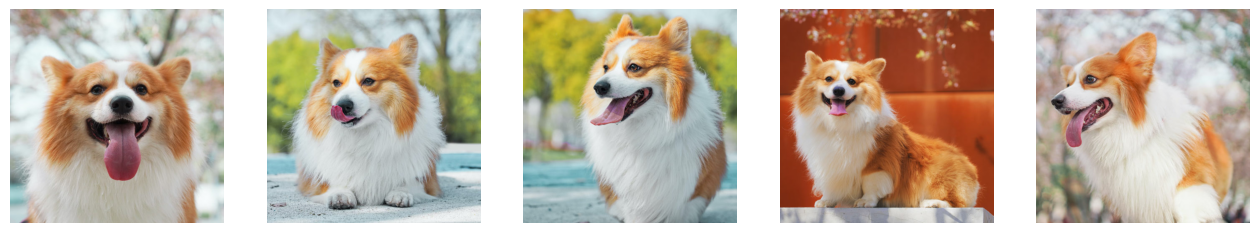

In [12]:
plot_images(instance_images)

**Class images (Prior)**: These images are generated by the pre-trained model itself.

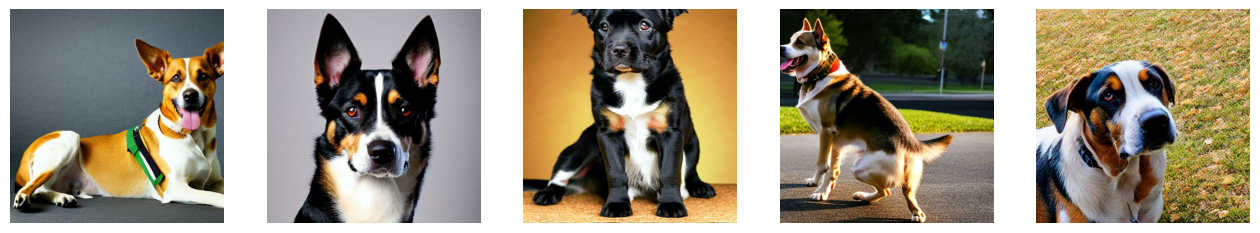

In [13]:
plot_images(class_images)

### Prepare datasets
In training, we pass a pair of instance and class data in each step.<br>
But since the lengths of these datasets are different (instance: 5, class: 200), let's repeat the instance dataset and set the same length.

To do this, we can simply call `.repeat()` method of `tf.data.Dataset`.

In [14]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

instance_len = instance_images.cardinality() # 5
class_len = class_images.cardinality() # 200
ds_len = instance_len * (class_len // instance_len)

instance_images = instance_images.repeat(class_len // instance_len)
class_images = class_images.take(ds_len)

#### Prepare the prompts
Each dataset includes two components: prompt and image. Let's preprocess both of them.

The prompts dataset is straightforward.
We simply repeat the instance prompt (`"a photo of a hta dog"`) and class prompt (`"a photo of a dog"`) in each step.

Since Keras CV includes a pre-trained `SimpleTokenizer`, we can use it to tokenize these prompts.

Note that the length of the prompt token (`MAX_PROMPT_LENGTH`) and padding token index (`PADDING_TOKEN`) come from this tokenizer and text encoder.<br>
In the Keras CV implementation, a CLIP text encoder is used.

Please refer to [the source code](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/text_encoder.py) for more details of the text encoder and these hyperparameters.

In [15]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

# Refererence: https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/text_encoder.py
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# We just repeat the prompts / captions per images.
unique_id = "hta"
class_label = "dog"

instance_prompt = f"a photo of a {unique_id} {class_label}"
class_prompt = f"a photo of a {class_label}"

# Load the tokenizer.
tokenizer = keras_cv.models.stable_diffusion.SimpleTokenizer()

# Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return tokens

tokenized_instance_prompt = process_text(instance_prompt)
tokenized_class_prompt = process_text(class_prompt)

instance_prompt_ds = \
    tf.data.Dataset.from_tensor_slices([tokenized_instance_prompt]).repeat(ds_len)
class_prompt_ds = \
    tf.data.Dataset.from_tensor_slices([tokenized_class_prompt]).repeat(ds_len)

In [16]:
print(f"{'='*10} Instance Prompt Token {'='*10}")
for d in instance_prompt_ds.take(1):
    print(d)

print(f"{'='*10} Class Prompt Token {'='*10}")
for d in class_prompt_ds.take(1):
    print(d)

========== Instance Prompt Token ==========
tf.Tensor(
[49406   320  1125   539   320 49384  1929 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407], shape=(77,), dtype=int32)
========== Class Prompt Token ==========
tf.Tensor(
[49406   320  1125   539   320  1929 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 

#### Prepare the images

For images, we set up standard preprocessing and a few data argumentation.

In [17]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

resolution = 512
auto = tf.data.AUTOTUNE

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(resolution, resolution),
        keras_cv.layers.RandomFlip(),
        keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)

def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    return image, tokenized_text


def apply_augmentation(image_batch, tokenized_texts):
    return augmenter(image_batch), tokenized_texts

#### Assemble dataset

Now, let's assemble the prompt and image dataset with `tf.data.Dataset.zip()` method.

Note that the final dataset consists of a dictionary with two keys (`"***_images"` and `"***_texts"`).

In [18]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

def prepare_dict(instance_only=True):
    def fn(image_batch, tokenized_texts):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_texts": tokenized_texts,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_texts": tokenized_texts,
            }
            return batch_dict

    return fn


def assemble_dataset(
    image_ds, tokenized_ds, instance_only=True, batch_size=1
):
    dataset = tf.data.Dataset.zip((image_ds, tokenized_ds))
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
    return dataset


BATCH_SIZE = 1

instance_dataset = assemble_dataset(
    instance_images,
    instance_prompt_ds,
    batch_size=BATCH_SIZE,
)
class_dataset = assemble_dataset(
    class_images,
    class_prompt_ds,
    instance_only=False,
    batch_size=BATCH_SIZE,
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

Now that the dataset has been prepared, let's quickly check the shape of each feature.

In [19]:
for d in train_dataset.take(1):
    for idx in range(len(d)):
        print(d[idx].keys())
        for key in d[idx].keys():
            print(f"shape of {key:15s}: {d[idx][key].shape}")

dict_keys(['instance_images', 'instance_texts'])
shape of instance_images: (1, 512, 512, 3)
shape of instance_texts : (1, 77)
dict_keys(['class_images', 'class_texts'])
shape of class_images   : (1, 512, 512, 3)
shape of class_texts    : (1, 77)


### DreamBooth training loop
Now let's define the main model class for training as `DreamBoothTrainer` class.

First, please remember that Stable Diffusion consists of multiple models, including:
- Text Encoder (`StableDiffusionV2.text_encoder`)
- Diffusion Model (`StableDiffusionV2.diffusion_model`)
- Variational AutoEncoder (`StableDiffusionV2.image_encoder` and `StableDiffusionV2.decoder`)

We simply start the training from the pre-trained weights. Note that we just construct them in the `__init__`  below.<br>
We fine-tune the text encoder and diffusion model but freeze the VAE encoder. VAE decoder is unnecessary in training, since we can compute loss in latent space.

`train_step()` is the main function where the fine-tuning process is defined using class and instance prompts.<br>
Note that the class and instance data are concatenated first and passed to the training process defined in `with tf.GradientTape` which roughly includes:
1. **Prompt Encoding**: The pre-trained text encoder is used.
2. **Image Encoding** The VAE encoder is used. Note that `sample_from_encoder_outputs()` function takes care of sampling from VAE's latent space. (Please refer to the VAE notebook if you are unfamiliar with this idea.)
3. **Forward Diffusion Process**: Sample noise and add it to the image.
4. **Reversed Diffusion Process (Diffusion Model Prediction)** The U-Net based diffusion model predicts the noise from the noisy image.
5. **Loss Computation**: Loss is the simple MSE as the standard diffusion models. As defined in `compute_loss()` function, we can optionally add weight to balance class and instant loss.

After computing loss, we compute the loss with respect to the diffusion model and text encoder, and update them, respectively. (VAE is frozen.)

In [20]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

class DreamBoothTrainer(tf.keras.Model):
    def __init__(
        self,
        sd_model,
        noise_scheduler,
        max_prompt_length=77,  # Default is 77
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.sd_model = sd_model
        self.noise_scheduler = noise_scheduler
        self.max_prompt_length = max_prompt_length
        self.use_mixed_precision = use_mixed_precision
        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm

        self.diffusion_model = sd_model.diffusion_model
        self.text_encoder = sd_model.text_encoder

        self.image_encoder = sd_model.image_encoder
        self.image_encoder.trainable = False

    def compile(self, diffusion_optimizer, text_encoder_optimizer, loss):
        super().compile(loss=loss)
        self.diffusion_optimizer = diffusion_optimizer
        self.text_encoder_optimizer = text_encoder_optimizer
        
    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_text = instance_batch["instance_texts"]
        class_images = class_batch["class_images"]
        class_text = class_batch["class_texts"]

        images = tf.concat([instance_images, class_images], 0)
        tokenized_texts = tf.concat([instance_text, class_text], 0)
        batch_size = tf.shape(images)[0]
        POS_IDS = tf.convert_to_tensor(
            [list(range(self.max_prompt_length))], dtype=tf.int32
        )

        with tf.GradientTape(persistent=True) as tape:
            embedded_texts = self.text_encoder(
                [tokenized_texts, POS_IDS], training=True
            )

            # Project image into the latent space.
            latents = self.image_encoder(images, training=False)

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Sampled noise is the target 
            target = noise
            timestep_embedding = tf.map_fn(
                lambda t: self.sd_model._get_timestep_embedding(t, batch_size),
                timesteps,
                fn_output_signature=tf.float32,
            )[:, 0]

            # Predict the noise residual and compute loss.
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, embedded_texts],
                training=True,
            )
            loss = self.compute_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the text encoder and diffusion model.
        text_trainable_vars = self.text_encoder.trainable_variables
        diffusion_trainable_vars = self.diffusion_model.trainable_variables
        
        text_gradients = tape.gradient(loss, text_trainable_vars)
        diffusion_gradients = tape.gradient(loss, diffusion_trainable_vars)

        if self.use_mixed_precision:
            text_gradients = self.optimizer.get_unscaled_gradients(text_gradients)
            diffusion_gradients = self.optimizer.get_unscaled_gradients(diffusion_gradients)
        text_gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in text_gradients]
        diffusion_gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in diffusion_gradients]

        self.text_encoder_optimizer.apply_gradients(zip(text_gradients, text_trainable_vars))
        self.diffusion_optimizer.apply_gradients(zip(diffusion_gradients, diffusion_trainable_vars))

        return {m.name: m.result() for m in self.metrics}
    
    def compute_loss(self, target, model_pred):
        # Since the first half of the inputs has instance samples and the second half
        # has class samples, we do the chunking accordingly.
        model_pred, model_pred_prior = tf.split(
            model_pred, num_or_size_splits=2, axis=0
        )
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.compiled_loss(target, model_pred)

        # Compute prior loss.
        prior_loss = self.compiled_loss(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(
        self, filepath, overwrite=True, save_format=None, options=None
    ):
        # Overriding this method will allow us to customize which weights to save.
        # In this case, it will checkpoint the `diffusion_model` and `text_encoder`.
        self.diffusion_model.save_weights(
            filepath=f"{filepath}diffusion",
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

        self.text_encoder.save_weights(
            filepath=f"{filepath}text_encoder",
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

### Trainer initialization

So, let's construct the trainer and compile it as usual.

Note that we define two optimizers for the diffusion model and the text encoder, respectively, though it is still possible to train both with a single optimizer.<br>
By doing so, we can control the learning rates and the scheduling separately.<br>
Since Stable Diffusion is very sensitive to hyperparameters and it overfits/underfits easily, it is beneficial to have granular control.

In [21]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

def build_trainer(
    diffusion_learning_rate,
    text_learning_rate,
    diffusion_beta_1=0.9,
    diffusion_beta_2=0.999,
    text_beta_1=0.9,
    text_beta_2=0.999,
    diffusion_weight_decay=(1e-2,),
    text_weight_decay=(1e-2,),
    epsilon = 1e-08,
    use_mp=True # Set it to False if you're not using a GPU with tensor cores.
):
    if use_mp:
        tf.keras.mixed_precision.set_global_policy("mixed_float16")

    dreambooth_model = keras_cv.models.StableDiffusionV2(
        img_width=resolution, img_height=resolution, jit_compile=True
    )

    dreambooth_trainer = DreamBoothTrainer(
        sd_model=dreambooth_model,
        noise_scheduler=keras_cv.models.stable_diffusion.NoiseScheduler(),
        use_mixed_precision=use_mp,
    )

    diffusion_optimizer = tf.keras.optimizers.AdamW(
        learning_rate=diffusion_learning_rate,
        weight_decay=diffusion_weight_decay,
        beta_1=diffusion_beta_1,
        beta_2=diffusion_beta_2,
        epsilon=epsilon,
    )

    text_encoder_optimizer = tf.keras.optimizers.AdamW(
        learning_rate=text_learning_rate,
        weight_decay=text_weight_decay,
        beta_1=text_beta_1,
        beta_2=text_beta_2,
        epsilon=epsilon,
    )

    dreambooth_trainer.compile(
        diffusion_optimizer=diffusion_optimizer, 
        text_encoder_optimizer=text_encoder_optimizer,
        loss="mse")
    
    return dreambooth_trainer

#### Construct Tensorboard Callbacks (Optional)

In generative models training, qualitative evaluation (check the generated outputs instead quantitative metrics) is very important.
For this purpose, it's useful to define additional Tensorboard callback functions to check the training process with generative output.

The custom callback function `"ImageGenCallback"` is defined to generate images at the end of each epoch.<br>
For more details about the custom callback function, please refer to [the document](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks).

In [22]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

class ImageGenCallback(tf.keras.callbacks.Callback):
    def __init__(self, tensorboard_path, prompts, num_imgs_to_gen=3):
        self.tensorboard_path = tensorboard_path
        self.prompts = prompts
        self.num_imgs_to_gen = num_imgs_to_gen

    def log_image(self, prefix, prompt, step):
        images_dreamboothed = self.model.sd_model.text_to_image(
            prompt, batch_size=self.num_imgs_to_gen
        )
        logdir = f"{self.tensorboard_path}images"
        file_writer = tf.summary.create_file_writer(logdir)

        with file_writer.as_default():
            tf.summary.image(
                f"{prefix}: '{prompt}'",
                images_dreamboothed,
                step=step,
            )

    def on_train_begin(self, logs=None):
        prefix = "0_Initial Model"
        for p in self.prompts:
            self.log_image(prefix, p, step=0)

    def on_epoch_end(self, epoch, logs=None):
        prefix = f"{epoch+1}_Epoch {epoch+1}"
        for p in self.prompts:
            self.log_image(prefix, p, step=epoch+1)

def construct_tb_callbacks(tensorboard_path, prompts, num_imgs_to_gen=3):

    tf_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_path,
        write_graph=False,
    )

    return [tf_callback, ImageGenCallback(tensorboard_path, prompts, num_imgs_to_gen)]

### Training
We first calculate the number of epochs we need to train for.<br>
The paper suggests that 1000 steps with a learning rate 6e-6 (for Stable Diffusion) works for most cases. Still, it may require more steps or a different set of hyperparameters for more complicated or subtle objects like human faces.

Here, we use 1000 steps with a bit larger learning rate so that it can learn the pattern of the instance dog.

In [23]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

MAX_TRAIN_STEP = 1000

num_update_steps_per_epoch = ds_len // BATCH_SIZE
epochs = math.ceil(MAX_TRAIN_STEP / num_update_steps_per_epoch)

print(f"Training for {epochs} epochs.")

Training for 5 epochs.


This cell runs the training.<br>
But since we don't want to run it locally, we simply use `%%writefile` magic instead of `%%write_and_run` to write the file without execution.<br>
We will dispatch the cloud training job later.

If your local machine has A100 GPU attached, you can still run training with the command below. (Run this [bash file](../dreambooth_utils/create_a100_notebook.sh) if you want to create an A100 notebook instance.)

```python
output_base_dir = "dreambooth_outputs"
tensorboard_path = f"{output_base_dir}/logs/"

!rm -rf {output_base_dir}
os.makedirs(output_base_dir)

dreambooth_trainer= build_trainer(
    diffusion_learning_rate = 8e-6,
    text_learning_rate = 6e-7,
)

%load_ext tensorboard
%tensorboard --logdir {tensorboard_path}

callback_prompts = [f"A photo of a {unique_id} {class_label}"]

dreambooth_trainer.fit(
    train_dataset,
    epochs=epochs,
    callbacks=construct_tb_callbacks(tensorboard_path, callback_prompts),
)

os.makedirs(f"{output_base_dir}/checkpoints")
dreambooth_trainer.save_weights(f"{output_base_dir}/checkpoints/")
```

In [24]:
%%writefile -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

dreambooth_trainer= build_trainer(
    diffusion_learning_rate = 8e-6,
    text_learning_rate = 6e-7,
)

tensorboard_path = os.getenv("AIP_TENSORBOARD_LOG_DIR")

callback_prompts = [f"A photo of a {unique_id} {class_label}"]

dreambooth_trainer.fit(
    train_dataset,
    epochs=epochs,
    callbacks=construct_tb_callbacks(tensorboard_path, callback_prompts),
)

dreambooth_trainer.save_weights(os.getenv("AIP_CHECKPOINT_DIR"))

Appending to dreambooth_model/dreambooth_trainer.py


#### Cloud Training
Now, the entire training code is ready.<br>
We'll containerize the environment in a simple docker container and push it to the artifact registry.

In [25]:
%%writefile {TRAINING_APP_FOLDER}/Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-12.py310:latest
RUN pip install keras_cv==0.5.1 --upgrade --quiet

COPY . /code

WORKDIR /code

ENTRYPOINT ["python3", "dreambooth_trainer.py"]

Overwriting dreambooth_model/Dockerfile


In [26]:
IMAGE_NAME = "dreambooth_trainer"

!gcloud builds submit --tag gcr.io/{PROJECT}/{IMAGE_NAME} {TRAINING_APP_FOLDER}

Creating temporary tarball archive of 3 file(s) totalling 126.5 KiB before compression.
Uploading tarball of [dreambooth_model] to [gs://takumiohym-sandbox_cloudbuild/source/1694009235.403276-5b6f2f56406643f78cf9b3febe9f8310.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/takumiohym-sandbox/locations/global/builds/65637054-e7d6-41bc-bcd6-a69b115d9801].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/65637054-e7d6-41bc-bcd6-a69b115d9801?project=237937020997 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "65637054-e7d6-41bc-bcd6-a69b115d9801"

FETCHSOURCE
Fetching storage object: gs://takumiohym-sandbox_cloudbuild/source/1694009235.403276-5b6f2f56406643f78cf9b3febe9f8310.tgz#1694009235684628
Copying gs://takumiohym-sandbox_cloudbuild/source/1694009235.403276-5b6f2f56406643f78cf9b3febe9f8310.tgz#1694009235684628...
/ [1 files][  6.1 KiB/  6.1 KiB]                                                
Ope

We specify `NVIDIA_TESLA_A100` in the worker pool spec. Training takes ~30 minutes with A100 GPU.

**However, since A100 GPU is in high demand, the training execution command would return fail because of a resource error.**<br>
 <span style="color:red">**Even if you see a resource error, please feel free to skip this cell.**</span><br>
 <span style="color:red">**We already ran the training for you in the same setup and saved the result. You can check it in the next section.**</span><br>

In [ ]:
TRAIN_CONTAINER_URI = f"gcr.io/{PROJECT}/dreambooth_trainer"

TRAIN_MACHINE_TYPE = "a2-highgpu-1g"
TRAIN_ACCELERATOR_TYPE = "NVIDIA_TESLA_A100"
TRAIN_NUM_GPU = 1

RESOLUTION = 512
REGION = "us-central1"

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": TRAIN_MACHINE_TYPE,
            "accelerator_type": TRAIN_ACCELERATOR_TYPE,
            "accelerator_count": TRAIN_NUM_GPU,
        },
        "replica_count": 1,
        "disk_spec": {
            "boot_disk_type": "pd-ssd",
            "boot_disk_size_gb": 500,
        },
        "container_spec": {
            "image_uri": TRAIN_CONTAINER_URI,
            "command": [],
        },
    }
]

TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
JOB_NAME = f"dreambooth_training_{TIMESTAMP}"

train_job = aiplatform.CustomJob(
    display_name=JOB_NAME,
    project=PROJECT,
    location=REGION,
    worker_pool_specs=worker_pool_specs,
    base_output_dir=f"gs://{BUCKET}/dreambooth_outputs/{JOB_NAME}",
    staging_bucket=f"gs://{BUCKET}",
)

train_job.run()

### Inference

Now, let's take a look at the result!

Replace `output_base_dir` to your bucket if you could run the training with A100.<br>
(Or local path if you run it locally.)

In [48]:
# Pre-trained weights
output_base_dir = "gs://asl-public/model_checkpoints/dreambooth_trained"

# Your cloud training destination path
# output_base_dir = f"gs://{BUCKET}/dreambooth_outputs/{JOB_NAME}"

# Or local training output path
# output_base_dir = "dreambooth_outputs"

You can check how the fine-tuning process went using the tensorboard thanks to the tensorboard callbacks we added.

In [49]:
%load_ext tensorboard
%tensorboard --logdir {output_base_dir}/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


How does it look? We can see that the model is gradually obtaining the concept of the instance in the training process.

Next, let's load the checkpoint of the fine-tuned model.

In [50]:
# Load stable diffusion weights
stable_diffusion_model.diffusion_model.load_weights(
    f"{output_base_dir}/checkpoints/diffusion"
)
stable_diffusion_model.text_encoder.load_weights(
    f"{output_base_dir}/checkpoints/text_encoder"
)

You can generate images with a prompt.<br>
Note how the unique identifier and the class have been used in the prompt.

Feel free to experiment with different prompts (Remember to add the unique identifier and the class label!) to see how the results change. 

In [51]:
def plot_inference(prompts, num_imgs_to_gen, num_steps=50):
    images_dreamboothed = stable_diffusion_model.text_to_image(
        prompt, batch_size=num_imgs_to_gen, num_steps=num_steps
    )

    plt.figure(figsize=(20, 20))
    for i in range(len(images_dreamboothed)):
        ax = plt.subplot(1, num_imgs_to_gen, i + 1)
        plt.title(prompts)
        plt.imshow(images_dreamboothed[i])
        plt.axis("off")

50/50 [==============================] - 6s 126ms/step


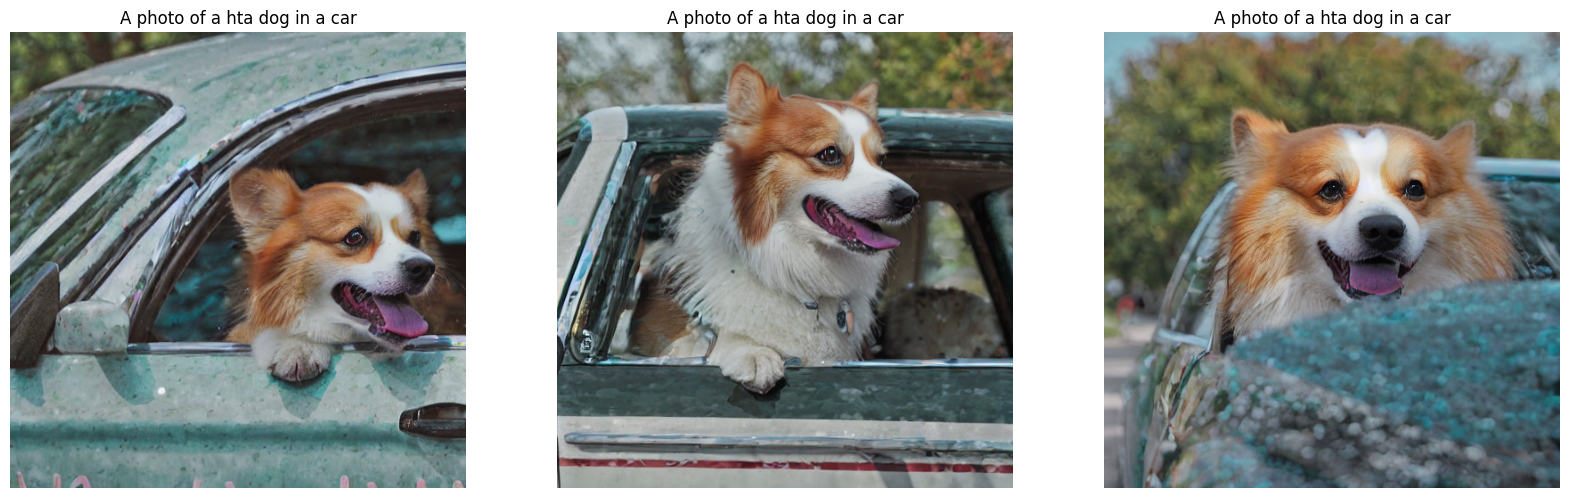

In [52]:
prompt = f"A photo of a {unique_id} {class_label} in a car"

plot_inference(prompt, 3)

50/50 [==============================] - 6s 127ms/step


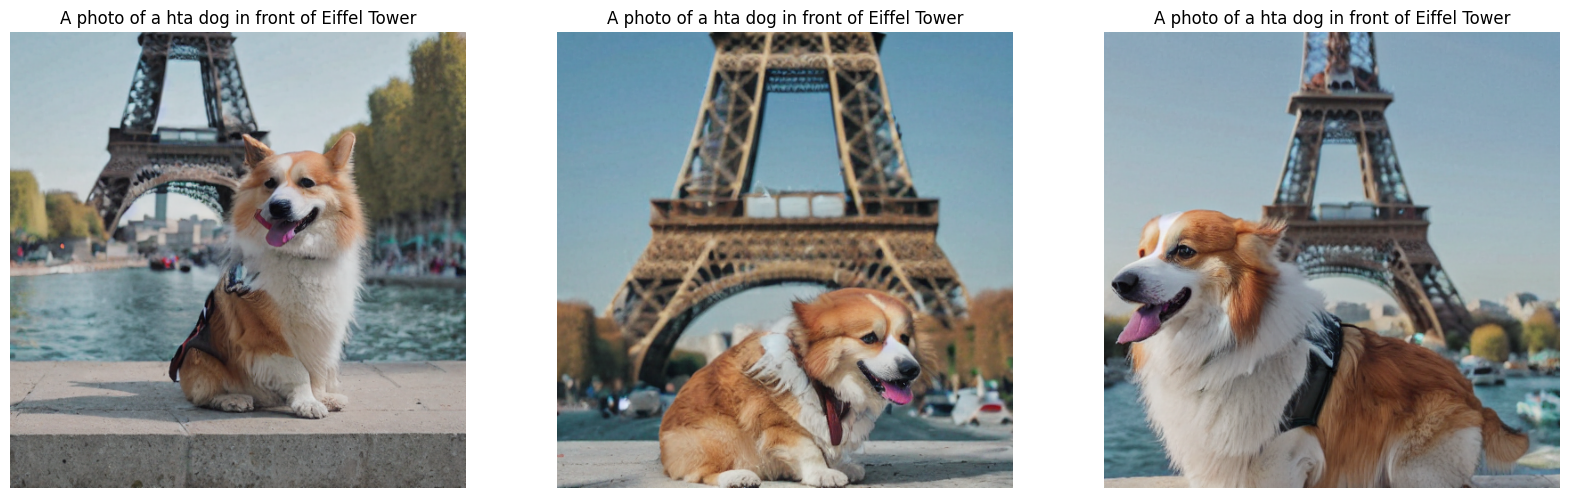

In [56]:
prompt = f"A photo of a {unique_id} {class_label} in front of Eiffel Tower"
plot_inference(prompt, 3)

50/50 [==============================] - 6s 127ms/step


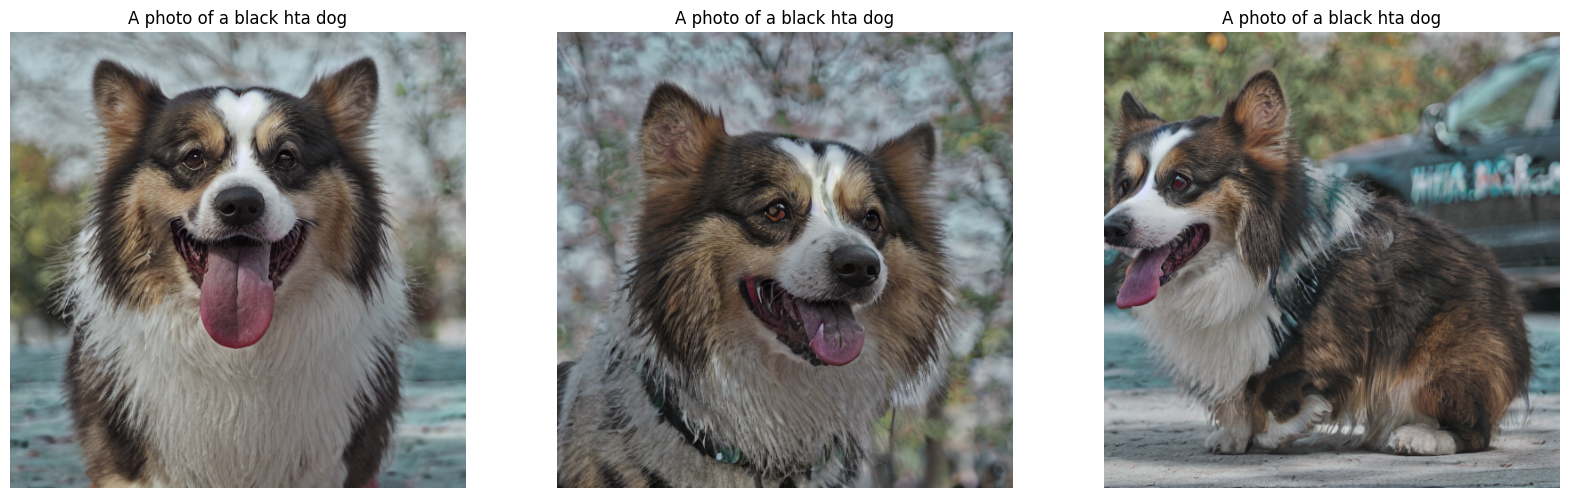

In [54]:
prompt = f"A photo of a black {unique_id} {class_label}"

plot_inference(prompt, 3)

Also, let's check if our model doesn't forget the general concept of dog by removing the identifier.

50/50 [==============================] - 6s 127ms/step


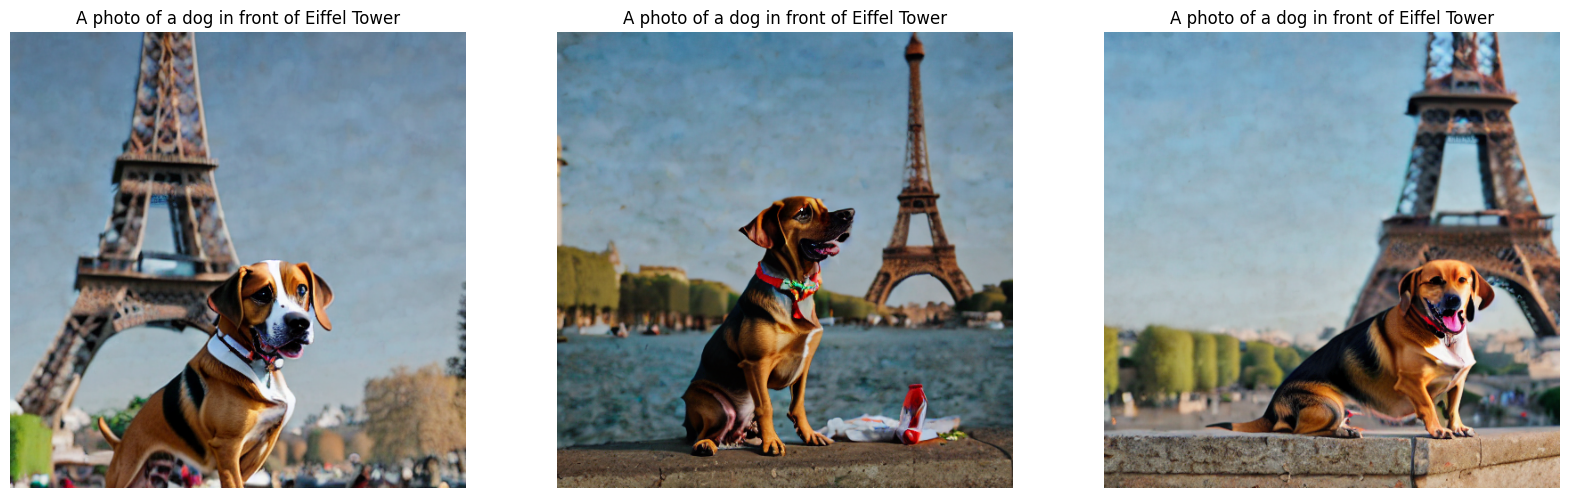

In [55]:
prompt = f"A photo of a {class_label} in front of Eiffel Tower"
plot_inference(prompt, 3)

## Acknowledgements
This notebook code is based on a [Keras official tutorial by Sayak Paul and Chansung Park](https://keras.io/examples/generative/dreambooth/).